<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 2 : Comparaison de méthodes <br>de groupement sur des données biomédicales

## Résumé

L'objectif de ce laboratoire est de comparer deux méthodes de groupement : _k_-moyennes et DBSCAN.  

Le jeu de données vient du domaine biomédical et possède une annotation de référence.  

Les tâches demandées sont les suivantes :
* préparer les données à partir de données brutes disponibles en ligne
* pour chaque méthode de groupement
  - décider quels sont les meilleurs hyper-paramètres par évaluation intrinsèque
  - avec ces paramètres, afficher aussi les scores par évaluation extrinsèque
  - visualiser les groupements en 2D
* comparer les deux méthodes de groupement et conclure.

### **Nom et prénom :** Julien Mühlemann et Cristhian Ronquillo

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = "1" # KMeans is known to have a memory leak ... set OMP_NUM_THREADS=1

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.metrics import silhouette_score as sis
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.metrics import f1_score

from matplotlib.colors import Normalize # peut aider au coloriage des groupes (ou utiliser Seaborn)

## 1. Prise en main et analyse exploratoire des données

Les données biomédicales ont été présentées dans l'article de Todd R. Golub et al., [Molecular classification of cancer: class discovery and class prediction by gene expression monitoring](https://www.science.org/doi/abs/10.1126/science.286.5439.531), *Science*, 286:531-537, 1999.  Ces données représentent l'expression de **7129 gènes** dans des échantillons sanguins et de moëlle osseuse provenant de 72 patients souffrant de leucémie.  Pour chaque gène, son niveau d'expression est codé comme un nombre entier, positif ou négatif.  Le type de leucémie a été annoté pour chaque patient comme ALL ou AML (*acute lymphoblastic leukemia* ou *acute myeloid leukemia*) : ce sont les deux classes de référence.

Les données sont à télécharger depuis [une version fournie par C. Crawford sur Kaggle](https://www.kaggle.com/datasets/crawford/gene-expression) (pour information, une autre version se trouve dans le [package R golubEsets](https://master.bioconductor.org/packages/release/data/experiment/html/golubEsets.html)).  Si vous n'avez pas accès à Kaggle, le fichier `archive.zip` est fourni avec ce notebook.  Les données brutes contiennent :
* un fichier `train` avec les données de 38 patients : noms des gènes (longs et courts), niveau d'expression, signifiance ('call')
* un fichier `independent` avec les données de 34 autres patients
* un fichier `actual` qui indique pour chaque patient son type de leucémie (ALL ou AML)

**Le premier but est d'obtenir une DataFrame avec les 72 patients (lignes) et les niveaux des 7129 gènes (colonnes).  Le numéro de patient sert d'index.  Enfin, une colonne indiquera le type de chaque patient.**

a. Veuillez compléter le code ci-dessous pour transformer le premier fichier de données en un tableau:
* avec 7129 colonnes correspondant à la valeur exprimée de chaque gène pour chaque patient
* les noms des 7129 colonnes sont les noms courts de chaque gène (connus comme *Gene Accession Number*) 
* indexé par le numéro des patients, qui sera appelé 'Patient'

In [197]:
actual = pd.read_csv("data/actual.csv")
independent = pd.read_csv("data/data_set_ALL_AML_independent.csv")
train = pd.read_csv("data/data_set_ALL_AML_train.csv")

In [198]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 78 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Gene Description       7129 non-null   object
 1   Gene Accession Number  7129 non-null   object
 2   1                      7129 non-null   int64 
 3   call                   7129 non-null   object
 4   2                      7129 non-null   int64 
 5   call.1                 7129 non-null   object
 6   3                      7129 non-null   int64 
 7   call.2                 7129 non-null   object
 8   4                      7129 non-null   int64 
 9   call.3                 7129 non-null   object
 10  5                      7129 non-null   int64 
 11  call.4                 7129 non-null   object
 12  6                      7129 non-null   int64 
 13  call.5                 7129 non-null   object
 14  7                      7129 non-null   int64 
 15  call.6               

In [199]:
def conversion_donnees_brutes(path : str) -> pd.DataFrame:
    # Retourne la DataFrame selon la consigne.
    # Code à compléter :
    # Retourne la DataFrame selon la consigne.
    # Code à compléter :

    # Importer les données
    data = pd.read_csv(path)

    # Extraire les colonnes de gènes
    genes = data.iloc[:, 2:].select_dtypes(include=["int64"])

    # Transposer les données des gènes pour que chaque colonne corresponde à un "Gene Accession Number"
    genes_transposed = genes.T

    # Attribuer les noms des colonnes en utilisant "Gene Accession Number"
    genes_transposed.columns = data["Gene Accession Number"]

    return genes_transposed



In [200]:
train_df = conversion_donnees_brutes(os.path.join('data', 'data_set_ALL_AML_train.csv'))
print(train_df.shape) # vérifie le résultat : (38, 7129)
train_df.head(3)

(38, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


b. Veuillez appliquer la même fonction au deuxième fichier de données.

In [201]:
test_df = conversion_donnees_brutes(os.path.join('data', 'data_set_ALL_AML_independent.csv'))
print(test_df.shape) # vérifier le résultat : (34, 7129)
test_df.head(3)

(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
42,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42


c. Veuillez fusionner les deux data frames en mettant les patients dans l'ordre 1 à 72.

In [202]:
# Veuillez écrire le code ici et appeler le résultat 'total_df'
total_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# trier les colonnes par ordre alphabétique
total_df = total_df.sort_index(axis=1)

total_df.head(3)

Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,AB000460_at,...,Z84721_cds2_at,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at
0,151,72,281,36,29,-299,-336,57,186,1647,...,8656,-156,538,434,168,116,-122,398,188,15091
1,263,21,250,43,8,-103,-361,169,219,2043,...,13285,-241,863,506,70,94,-40,649,147,11038
2,88,-27,358,42,11,142,-508,359,237,1997,...,15704,-581,737,770,141,57,-38,701,131,16692


d.  En utilisant le fichier `actual.csv`, veuillez ajouter à **total_df** une colonne intitulée **type**, qui indique pour chaque patient son type de maladie (ALL ou AML).  Attention, cette colonne servira uniquement pour l'évaluation extrinsèque en fin de labo.

In [203]:
# Veuillez écrire le code ici :
total_df['type'] = actual['cancer']

print(total_df.shape)
total_df.head()

(72, 7130)


Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,AB000460_at,...,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at,type
0,151,72,281,36,29,-299,-336,57,186,1647,...,-156,538,434,168,116,-122,398,188,15091,ALL
1,263,21,250,43,8,-103,-361,169,219,2043,...,-241,863,506,70,94,-40,649,147,11038,ALL
2,88,-27,358,42,11,142,-508,359,237,1997,...,-581,737,770,141,57,-38,701,131,16692,ALL
3,484,61,118,39,38,-11,-116,274,245,2128,...,-267,882,348,102,179,-58,533,448,15763,ALL
4,118,16,197,39,50,237,-129,311,186,1608,...,-235,386,484,123,66,-45,448,106,18128,ALL


e. Y a-t-il des données manquantes dans la Data Frame obtenue ?

In [204]:
# données manquantes
print(total_df.isnull().sum().sum())

0


Non, il n'y a pas de données manquantes dans la Data Frame obtenue.

f. Y a-t-il des *outliers* dans chaque colonne ?  Même s'il y en a, ne pas les supprimer.

In [205]:
# Chercher les outliers avec Z-score
from scipy import stats

# Calcul des Z-scores pour toutes les colonnes sauf la dernière
z = np.abs(stats.zscore(total_df.iloc[:, :-1]))

# Définir un seuil pour identifier les outliers
seuil = 3
outliers = (z > seuil)

n_outliers = outliers.sum().sum()

# Afficher les lignes avec des valeurs d'outliers
print("Outliers détectés : ", n_outliers)

Outliers détectés :  6332


In [240]:
outliers.sum()

Gene Accession Number
A28102_at         2
AB000114_at       2
AB000115_at       3
AB000220_at       2
AB000381_s_at     0
                 ..
Z95624_at         0
Z96810_at         0
Z97054_xpt2_at    1
Z97074_at         1
hum_alu_at        1
Length: 7129, dtype: int64

Oui, il y a des outliers dans pas mal de colonnes. Nous avons utilisé le score Z pour déterminer les outliers, avec un seuil de 3.

g. Veuillez donner un résumé pour chaque colonne numérique (le _5-number-summary_) en utilisant la méthode _describe()_.  Utiliser l'affichage par défaut qui affiche un petit nombre de colonnes.

In [207]:
total_df.describe()

Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,AB000460_at,...,Z84721_cds2_at,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,278.013889,30.805556,296.250000,44.444444,43.652778,24.722222,-276.000000,214.208333,179.222222,1824.083333,...,12260.125000,-280.055556,633.486111,313.847222,100.444444,104.125000,-25.597222,519.722222,147.138889,25209.180556
std,189.318979,66.629655,373.146414,47.778506,51.974577,203.801286,166.805782,182.164756,114.225404,562.957826,...,8804.104614,202.280372,269.558010,222.700308,64.898163,45.409231,53.121349,239.963625,155.112436,10882.622106
min,20.000000,-212.000000,65.000000,-61.000000,-108.000000,-520.000000,-663.000000,-41.000000,2.000000,714.000000,...,-52.000000,-1295.000000,29.000000,2.000000,-21.000000,20.000000,-122.000000,96.000000,-132.000000,6479.000000
25%,125.750000,-0.750000,126.250000,19.750000,8.750000,-82.250000,-365.500000,89.750000,99.750000,1434.500000,...,5462.500000,-357.250000,455.500000,168.750000,57.750000,64.750000,-58.250000,356.250000,54.000000,17783.250000
50%,255.000000,30.000000,184.000000,39.000000,43.500000,10.500000,-263.500000,173.500000,169.000000,1777.500000,...,10864.000000,-250.500000,602.000000,244.500000,88.000000,104.000000,-29.000000,485.500000,132.000000,21972.000000
75%,383.500000,64.250000,259.250000,53.000000,76.250000,125.000000,-145.750000,285.000000,219.250000,2119.750000,...,16231.750000,-159.000000,751.250000,424.000000,142.000000,136.750000,7.250000,643.250000,215.750000,30856.250000
max,1106.000000,249.000000,2194.000000,202.000000,147.000000,845.000000,64.000000,971.000000,556.000000,3570.000000,...,43434.000000,123.000000,1531.000000,1015.000000,298.000000,227.000000,114.000000,1244.000000,700.000000,58203.000000


Nous observons que les valeurs sont très dispersées, avec des valeurs minimales et maximales très différentes pour chaque colonne. Les valeurs médianes sont également très différentes d'une colonne à l'autre.

h. Combien de fois apparaît chaque classe de référence, ALL et AML ?

In [208]:
total_df["type"].value_counts()

type
ALL    47
AML    25
Name: count, dtype: int64

i. Appliquez la PCA sur des données normalisées (sans la colonne `type`), en **deux** dimensions (sans normaliser le résultat). **Vous travaillerez sur ces données tout au long du labo.**

In [209]:
# Veuillez nommer X_pca le résultat de la PCA sur les colonnes de données.
# Veuillez nommer Y la colonne indiquant le type correct de chaque patient.

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(total_df.iloc[:, :-1])

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(scaled_df)
Y = total_df.iloc[:, -1]


k. À ce stade, après la PCA, les points vous semblent-ils présenter un groupement visible ?

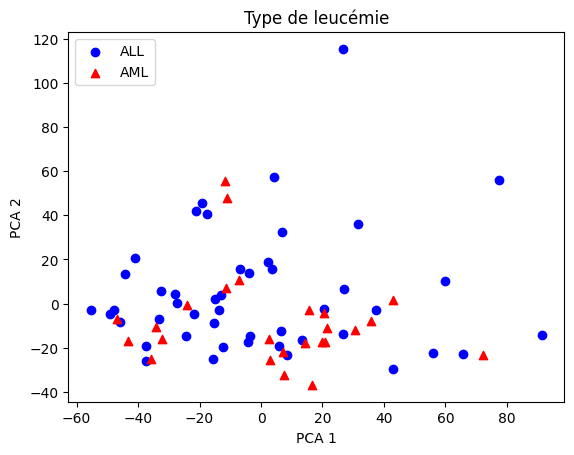

In [210]:
# Visualisation des composantes principales X_pca
# Ajout des étiquettes de colonnes pour X_pca pour plus de clarté
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

# Fusion des données PCA et des étiquettes dans un même DataFrame
X_pca_avec_label = pd.concat([X_pca_df, Y.rename("type")], axis=1)

# Tracé des points en fonction du type de leucémie
markers = {'ALL': 'o', 'AML': '^'}
colors = {'ALL': 'blue', 'AML': 'red'}

for label, group in X_pca_avec_label.groupby("type"):
    plt.scatter(group["PCA1"], group["PCA2"], color=colors[label], label=label, marker=markers[label])

plt.legend(loc="upper left")
plt.title("Type de leucémie")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Non, les points ne semblent pas présenter de groupement visible. Ils sont très dispersés et ne forment pas de clusters distincts. La PCA a effectivement réduit la dimensionnalité, mais elle a rendu le regroupement difficile à percevoir visuellement.

## 2. Groupement avec _k_-moyennes

Dans cette section, on vous demande de grouper les patients en utilisant la méthode des _k_-moyennes (avec initialisation _kmeans++_) et de trouver la valeur optimale du nombre de groupes entre 2 et 12, en utilisant l'indice de Davies-Bouldin et le score Silhouette.  Vous *ne* devez *pas* utiliser l'information du type de maladie.

Vu le nombre élevé d'attributs, vous réutiliserez les résultat de l'ACP faite ci-dessus, sans normalisation après l'ACP.

a. Pour les trois scores suivants, veuillez rappeler (en utilisant la documentation de sklearn) quel est leur intervalle de valeurs et quelles valeurs indiquent un meilleur groupement :
* l'indice de Davies-Bouldin
* le coefficient de Silhouette
* l'inertie.

**Indice de Davies-Bouldin :**  
L'indice de Davies-Bouldin varie entre 0 (meilleure classification) et +$\infty$ (pire classification).

**Coefficient de Silhouette :**  
Le coefficient de silhouette varie entre -1 (pire classification) et 1 (meilleure classification).

**Inertie (within-cluster sum-of-squares criterion, WCSS) :**  
L'inertie est une mesure non bornée qui dépend des données et du nombre de clusters. Plus le nombre de clusters est élevé, plus l'inertie tend à diminuer. Plus l'inertie est basse, mieux c'est. Une inertie faible indique que les points sont proches des centres de leurs clusters respectifs, ce qui signifie que les clusters sont compacts. Toutefois, il est important de noter que l'inertie diminue toujours avec l'augmentation du nombre de clusters, donc elle doit être interprétée avec précaution (par exemple, en combinaison avec d'autre méthode comme la méthode du coude).

---

b. Pour un nombre de groupes _k_ allant de 2 à 12 compris, veuillez effectuer le groupement avec _k_-moyennes, puis représenter sur trois graphiques la variation des trois scores intrinsèques en fonction de _k_.  Utiliser `n_init=10`.

In [211]:
from sklearn import metrics

scores_davies_bouldin = []
scores_silhouette = []
scores_inertie = [] 

for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, n_init=10, init="k-means++", random_state=0).fit(X_pca)
    score_davies_bouldin = metrics.davies_bouldin_score(X_pca, kmeans.labels_)
    score_silhouette = metrics.silhouette_score(X_pca, kmeans.labels_)
    score_inertie = kmeans.inertia_

    # Stocker scores
    scores_davies_bouldin.append(score_davies_bouldin)
    scores_silhouette.append(score_silhouette)
    scores_inertie.append(score_inertie)


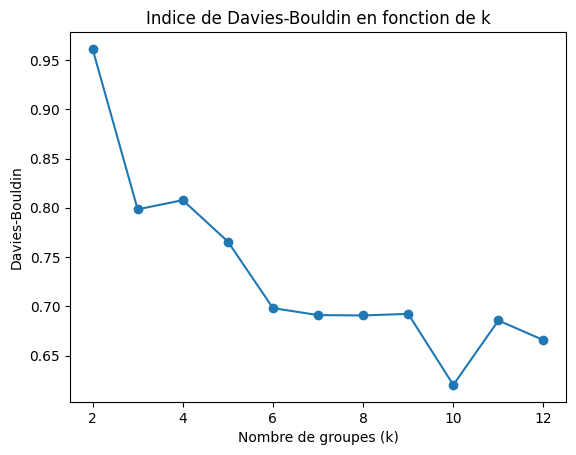

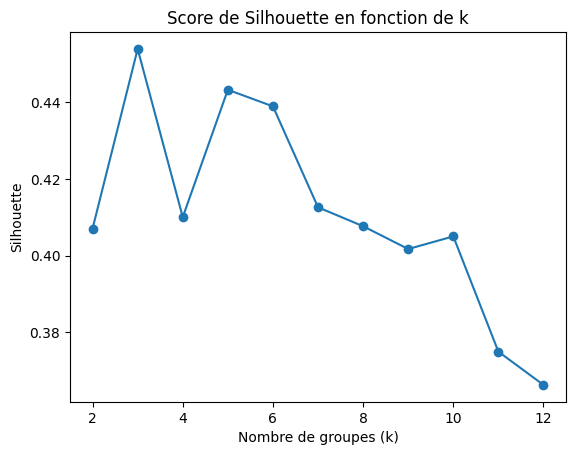

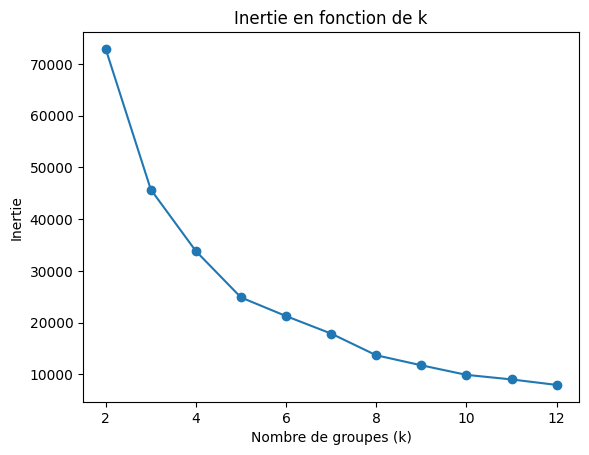

In [212]:
# Abscisse des métriques
x = range(2, 13, 1)

# Graphique de l'indice de Davies-Bouldin
plt.plot(x, scores_davies_bouldin, marker="o")
plt.title('Indice de Davies-Bouldin en fonction de k')
plt.xlabel('Nombre de groupes (k)')
plt.ylabel('Davies-Bouldin')
plt.show()

# Graphique du score de Silhouette
plt.plot(x, scores_silhouette, marker="o")
plt.title('Score de Silhouette en fonction de k')
plt.xlabel('Nombre de groupes (k)')
plt.ylabel('Silhouette')
plt.show()

# Graphique de l'inertie
plt.plot(x, scores_inertie, marker="o")
plt.title('Inertie en fonction de k')
plt.xlabel('Nombre de groupes (k)')
plt.ylabel('Inertie')
plt.show()

c. Selon les courbes affichées, quelle valeur de _k_ proposez-vous de retenir ?  Veuillez donner une raison.

Si vous exécutez plusieurs fois l'affichage des courbes, la valeur optimale de _k_ reste-t-elle la même ?  Que pouvez-vous en conclure ?

Note : si vous fixez l'attribut `random_seed` de KMeans, alors les courbes ne varient pas au fil des exécutions, sauf si vous changez `n_init`.

### Votre discussion indices :

***Indice de Davies-Bouldin*** : Nous observons que l'indice de Davies-Bouldin diminue régulièrement jusqu'à k = 10, mais après k = 6, la diminution devient moins significative. Cela signifie qu'au-delà de k = 6, l'amélioration apportée par l'ajout de nouveaux clusters est marginale. Par conséquent, k = 6 semble être une valeur optimale si l'on cherche un compromis entre la qualité du clustering et la fragmentation des clusters.

***Coefficient de Silhouette*** : Le score de silhouette atteint son maximum pour k = 3, ce qui indique une meilleure cohésion et séparation des clusters à cette valeur. Cependant, bien que k = 3 ait le meilleur score, il peut entraîner une simplification excessive avec moins de clusters, ce qui pourrait ne pas capturer toutes les nuances de la segmentation.

***Inertie*** : En utilisant la méthode du coude, on observe que la réduction de l'inertie ralentit à partir de k = 5. Cela signifie que l'ajout de nouveaux clusters au-delà de k = 5 n'apporte que peu d'améliorations en termes de compacité des clusters, ce qui en fait un bon candidat pour la valeur optimale de k.

**Conclusion** : En prenant en compte les trois métriques, un bon compromis serait de choisir k = 5. Cette valeur permet d'équilibrer la cohésion des clusters (proche de k = 3 pour le coefficient de silhouette), tout en maintenant une séparation et une compacité acceptables des clusters (proche de k = 6 pour l'indice de Davies-Bouldin et l'inertie). Cela offre une bonne granularité sans sur-fragmenter les données.

>Si vous exécutez plusieurs fois l'affichage des courbes, la valeur optimale de _k_ reste-t-elle la même ?  

La valeur optimale de k peut effectivement changer d'une exécution à l'autre en raison de l'absence d'une initialisation stricte dans l'algorithme des k-moyennes. Pour résoudre ce problème et garantir des résultats reproductibles, j'ai ajouté random_state = 0, ce qui permet de fixer l'initialisation aléatoire et d'obtenir des résultats cohérents à chaque exécution.

***Note :*** J'ai exécuté le code plusieurs fois sans spécifier de random_state et j'ai effectivement obtenu des valeurs optimales de k différentes à chaque exécution. Cependant, en cherchant un compromis entre les trois scores (Davies-Bouldin, silhouette, et inertie), j'ai constaté que k = 5 revenait dans la majorité des cas.

---

d. Avec la valeur de _k_ choisie au (c), veuillez calculer deux scores extrinsèques : l'indice de Rand ajusté et le score F1.  Veuillez commenter brièvement ces scores.

_Indication pour calculer le F1-score, qui n'est pas implémenté dans sklearn pour le groupement._  Pour chaque patient, assignez-lui le type qui est majoritaire dans son groupe (ALL ou AML) en utilisant les bonnes réponses.  Puis comparez les types ainsi assignés avec les types corrects en utilisant directement le score F1 de sklearn.  Notez que pour simplifier, cette méthode est un peu différente de celle du cours.

In [230]:
# Effectuer le groupement k-moyennes avec la meilleure valeur de k retenue au (b).

k = 5 #nombre de clusters
kmeans = KMeans(n_clusters=k, n_init=10, init="k-means++", random_state=0).fit(X_pca)

In [231]:
from sklearn.metrics import adjusted_rand_score, f1_score
from collections import Counter

# Étiquettes de clustering prédictes
predicted_labels = kmeans.labels_

# Étiquettes réelles (Y) : Types de maladies (ALL ou AML)
true_labels = Y 

# Calculer score rand
score_rand = adjusted_rand_score(true_labels, predicted_labels)
print(f"Indice de Rand ajusté : {score_rand}")

# Calculer socre F1-score

# Assignation des types majoritaires à chaque cluster pour calculer le F1-score
cluster_to_majority_label = {}

for cluster in range(k):
    # Obtenir les indices des points dans le cluster
    cluster_points = np.where(predicted_labels == cluster)[0] # np.where[0] retourne un tuple et on veut le premier élément avec les indices correspondants
    
    # Trouver les étiquettes réelles correspondantes
    cluster_labels = true_labels[cluster_points]
    
    # Trouver l'étiquette majoritaire
    majority_label = Counter(cluster_labels).most_common(1)[0][0] # most_common(1) retourne une liste de tuples, 1 étant le nombre d'occurrences le plus élevé
    # [0][0] pour obtenir la première étiquette majoritaire

    cluster_to_majority_label[cluster] = majority_label

# Assigner les étiquettes majoritaires aux patients
assigned_labels = np.array([cluster_to_majority_label[cluster] for cluster in predicted_labels])

# Calculer le F1-score
f1 = f1_score(true_labels, assigned_labels, average='weighted')
print(f"F1-score : {f1}")


Indice de Rand ajusté : 0.022252240029729427
F1-score : 0.6873952479542541


### Votre commentaire sur les scores :
***Indice de Rand ajusté (ARI) :*** 0.022  

L'indice de Rand ajusté (ARI) est très proche de 0, ce qui suggère que les clusters trouvés par l'algorithme des k-moyennes ne correspondent pas bien aux étiquettes réelles (ALL ou AML). Un ARI proche de 0 signifie que la partition est quasiment aléatoire, tandis qu'un ARI proche de 1 indiquerait une correspondance parfaite. Un score aussi faible montre que le modèle KMeans ne capture pas bien la structure des données par rapport aux étiquettes de maladie.

***F1-score :*** 0.687  

Le F1-score de 0.687 est relativement bon, ce qui signifie que, même si l'alignement général entre les clusters et les classes réelles (ALL/AML) est faible (comme l'indique l'ARI), le regroupement des données permet tout de même d'assigner correctement les étiquettes majoritaires dans chaque cluster dans de nombreux cas.
Un F1-score élevé montre que le modèle est capable de bien classifier un grand nombre de patients correctement, malgré la mauvaise composition des clusters détectée précendemment.

**Conclusion :** Le contraste entre l'ARI faible et le F1-score relativement élevé peut être dû à une mauvaise séparation globale des clusters (ce qui diminue l'ARI), mais avec quelques clusters qui contiennent une majorité d'un type de maladie (ce qui améliore le F1-score). Cela indique que les clusters ne correspondent pas bien aux vrais types de maladies dans leur globalité, mais certains clusters peuvent contenir une majorité de patients d'une seule classe (d'où le F1-score plus élevé).

---

e. Veuillez représenter les points avec PCA en 2D, en gardant les marqueurs précédents pour les deux types (cercle et triangle), et en utilisant des couleurs pour coder les groupes trouvés. Suggestion : réutiliser le code du Labo 1.  Veuillez commenter le résultat.

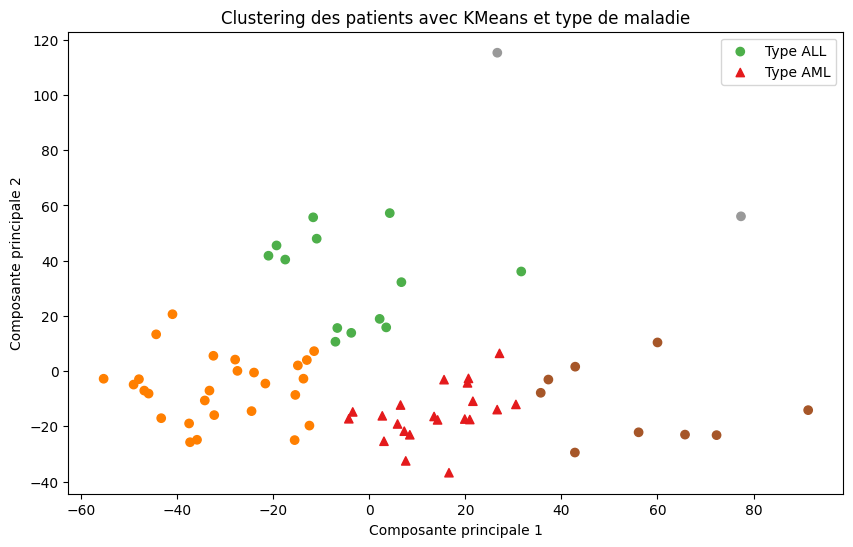

In [238]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Limiter la colormap à k couleurs (nombre de clusters)
cmap = plt.get_cmap('Set1', k)
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(k+1)-0.5, ncolors=k)  # Crée une norme discrète

# Dictionnaire pour les marqueurs en fonction des types de maladie
markers = {'ALL': 'o', 'AML': '^'}

# Boucle sur chaque type de maladie pour tracer les points par cluster
for label in np.unique(assigned_labels):
    marker = markers[label]  # Marqueur pour chaque type de maladie
    mask = (assigned_labels == label)      # Masque pour sélectionner les points de ce type
    
    # Affichage des points pour chaque type de maladie avec les couleurs des clusters
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=predicted_labels[mask], cmap=cmap, norm=norm, marker=marker, label=f'Type {label}')

# Paramètres du graphique
plt.title('Clustering des patients avec KMeans et type de maladie')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.show()


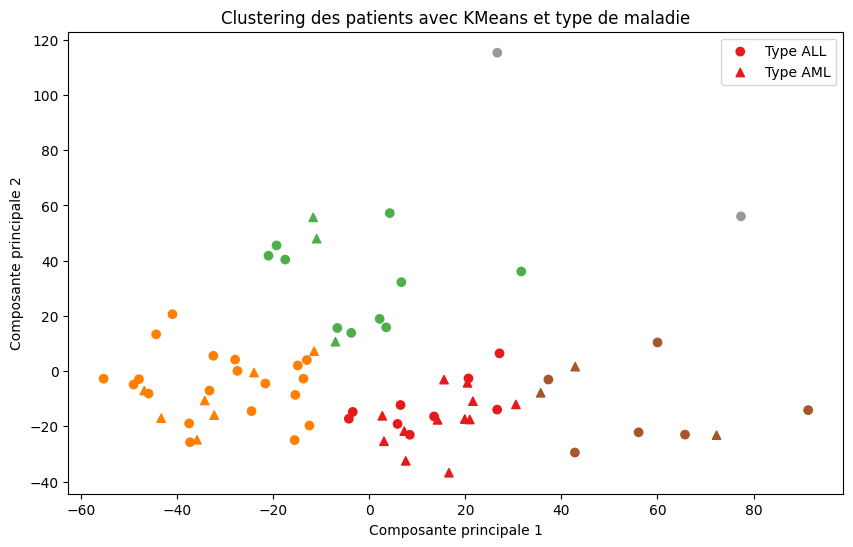

In [239]:
plt.figure(figsize=(10, 6))

# Limiter la colormap à k couleurs (nombre de clusters)
cmap = plt.get_cmap('Set1', k)
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(k+1)-0.5, ncolors=k)  # Crée une norme discrète

# Dictionnaire pour les marqueurs en fonction des types de maladie
markers = {'ALL': 'o', 'AML': '^'}

# Boucle sur chaque type de maladie pour tracer les points par cluster
for label in np.unique(Y):
    marker = markers[label]  # Marqueur pour chaque type de maladie
    mask = (Y == label)      # Masque pour sélectionner les points de ce type
    
    # Affichage des points pour chaque type de maladie avec les couleurs des clusters
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=predicted_labels[mask], cmap=cmap, norm=norm, marker=marker, label=f'Type {label}')

# Paramètres du graphique
plt.title('Clustering des patients avec KMeans et type de maladie')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.show()


### Veuillez écrire ici votre discussion des résultats, à l'aide du graphique.
**Conclusion :** En observant les graphiques, que l'on utilise ou non les classes majoritaires, on remarque que chaque cluster est principalement composé d'une classe dominante. Cependant, les types de maladies (ALL et AML) ne sont pas toujours bien séparés dans tous les groupes, ce qui montre que le clustering ne parvient pas toujours à distinguer clairement ces deux types. Il faut dire que réduire les 7129 dimensions à seulement 2 via la PCA rend cette tâche particulièrement ardue. Avec si peu de dimensions, il devient visuellement difficile de répartir les 72 patients en deux groupes bien distincts.

En prenant en compte la classe majoritaire de chaque cluster, notre F1-score de 0,69 est assez satisfaisant. En revanche, l'indice de Rand ajusté, proche de 0, indique une partition presque aléatoire lorsqu’on ignore les classes majoritaires. Cela suggère que, même si le clustering capture en partie la structure des données, il reste un décalage significatif par rapport aux classes réelles des maladies.

## 3. Groupement avec DBSCAN

Dans cette section, vous répondrez aux mêmes questions que dans la section précédente, mais pour la méthode DBSCAN, en utilisant les mêmes mesures intrinsèques que ci-dessus (sauf l'inertie).

a. Veuillez représenter sur des _heatmaps_ la variation des deux scores intrinsèques et le nombre de groupes en fonction des paramètres _eps_ et _min_samples_ :
* chercher _eps_ entre 0.5 et 14 par sauts de 0.5
* chercher _min_samples_ entre 1 et 12

In [217]:
# Obtenir les deux scores et le nombre de groupes en variant les deux paramètres, les mettre dans des tableaux 2D

from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns

all_eps = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.6, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14]
min_sample = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

silhouette_scores = np.zeros((len(all_eps), len(min_sample)))
davies_bouldin_scores = np.zeros((len(all_eps), len(min_sample)))
n_clusters = np.zeros((len(all_eps), len(min_sample)))

for i, ep in enumerate(all_eps):
    for j, m in enumerate(min_sample):
        db = DBSCAN(eps=ep, min_samples=m).fit(X_pca)
        labels = db.labels_

        unique_labels = set(labels)
        n_clusters[i, j] = len(unique_labels)

# si on a au moins 2 clusters
        n_labels = len(unique_labels)
        if 2 <= n_labels <= len(X_pca) - 1:
            silhouette_scores[i, j] = silhouette_score(X_pca, labels)
            davies_bouldin_scores[i, j] = davies_bouldin_score(X_pca, labels)
        else:
            silhouette_scores[i, j] = np.nan
            davies_bouldin_scores[i, j] = np.nan


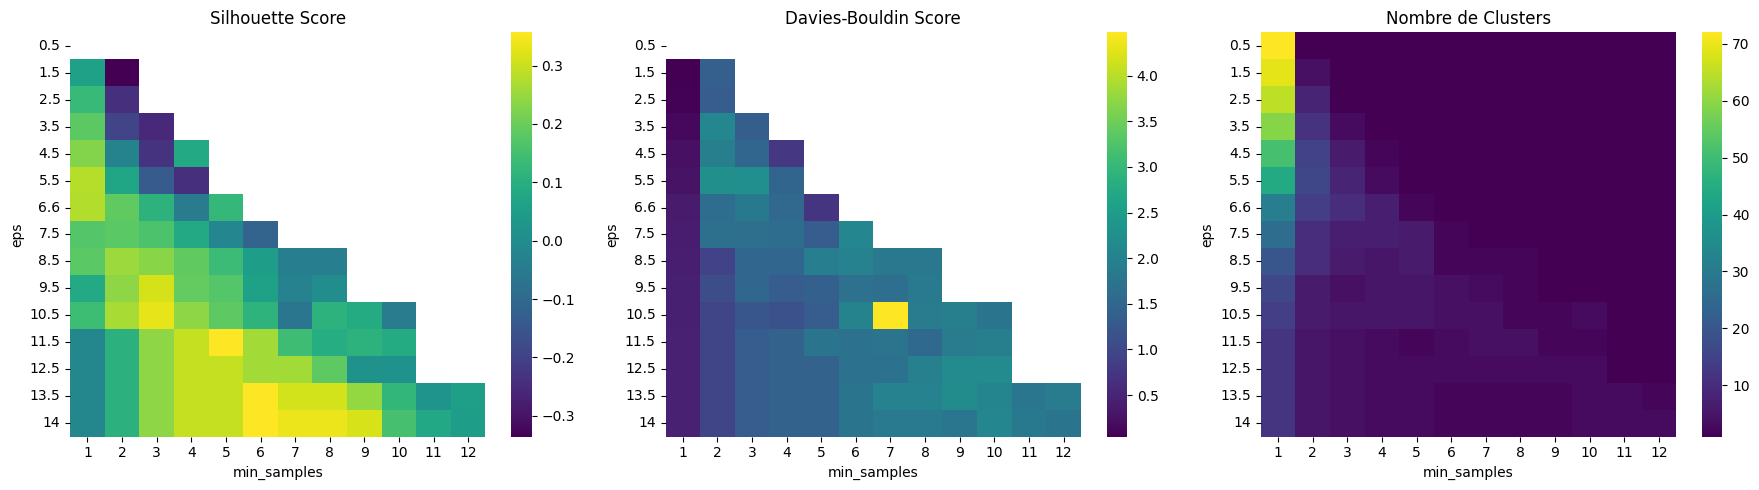

In [218]:
# Afficher les trois heatmaps : Davies_Bouldin, Silhouette, et Nombre_de_groupes
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(silhouette_scores, xticklabels=min_sample, yticklabels=all_eps, ax=ax[0], cmap='viridis')
ax[0].set_title('Silhouette Score')
ax[0].set_xlabel('min_samples')
ax[0].set_ylabel('eps')

sns.heatmap(davies_bouldin_scores, xticklabels=min_sample, yticklabels=all_eps, ax=ax[1], cmap='viridis')
ax[1].set_title('Davies-Bouldin Score')
ax[1].set_xlabel('min_samples')
ax[1].set_ylabel('eps')

sns.heatmap(n_clusters, xticklabels=min_sample, yticklabels=all_eps, ax=ax[2], cmap='viridis')
ax[2].set_title('Nombre de Clusters')
ax[2].set_xlabel('min_samples')
ax[2].set_ylabel('eps')

plt.tight_layout()
plt.show()

b. Selon les scores trouvés, quelles valeurs de _eps_ et _min_samples_ proposez-vous de retenir ?  Pourquoi ?

Attention : les trois heatmaps ne sont pas toujours en accord, donc vous avez une certaine liberté pour choisir les deux paramètres (il n'y a pas d'optimum évident).

### Votre discussion ici :  
#### Score silhouette:
les meilleures zones sont celles où les scores sont proches de 0.6 à 0.8, qui apparaissent pour des valeurs de eps comprises entre environ 11 et 14, avec un min_samples entre 4 et9.

#### Score Davies-Bouldin:
un score plus bas est meilleur. Sur cette heatmap, les valeurs basses (inférieures à 1.5) apparaissent autour de 11 <= eps <= 14 et min_samples < 6.

#### Nombre de clusters:
Il convient d'éviter des nombres de clusters trop élevés ou trop faibles. Par exemple, dans la zone où min_samples =1, le nombre de clusters est très élevé (jusqu'à 50 clusters). En revanche pour un min_sample > 6 le nombre de clusters est très faible (1 à 3 clusters).

Le compromis semble se situer pour des valeurs de eps autour de 11-12 avec min_samples entre 3 et 4, où le nombre de clusters reste raisonnable <= 10.

---

c. Avec les valeurs choisies au (b), veuillez calculer les deux scores extrinsèques comme dans la partie (2).

In [219]:
# Effectuer le groupement DBSCAN avec les meilleurs paramètres,
# puis calculer l'indice de Rand ajusté et le score F1.

from sklearn.preprocessing import LabelEncoder

eps_optimal = 11
min_samples_optimal = 3

db = DBSCAN(eps=eps_optimal, min_samples=min_samples_optimal).fit(X_pca)
labels_pred = db.labels_

ari_score = adjusted_rand_score(Y, labels_pred)
print(f"ARI indice de Rand: {ari_score}")


label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

f1 = f1_score(Y_encoded, labels_pred, average='weighted')
print(f"score F1: {f1}")

ARI indice de Rand: 0.03170347376901569
score F1: 0.5425925925925926


### Votre commentaire sur les scores :  
Avec les valeurs trouvées à l'aide des heatmaps (eps =11 et min_samples = 3), nous avons obtenu un score de rand de 0.032 et un score F1 de 54%.
Le score de rand est proche de 0 donc proche d'une classification aléatoire.

---

d. Veuillez représenter les points en 2D avec la même représentation que ci-dessus : utilisez des marques différentes pour les deux types, et des couleurs pour coder les groupes trouvés.  Veuillez commenter le résultat.

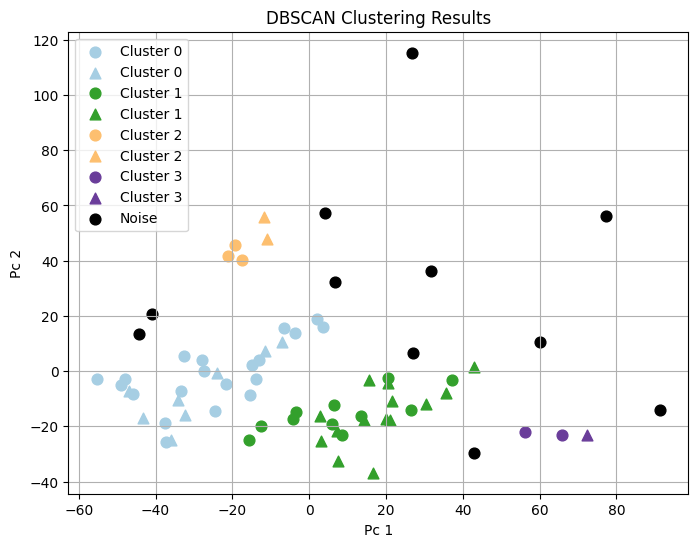

In [220]:
### Votre commentaire sur les scores :  
plt.figure(figsize=(8, 6))

unique_labels = set(labels_pred)
colors = plt.get_cmap("Paired", len(unique_labels))

marker_map = {'ALL': 'o', 'AML': '^'}

for k in unique_labels:
    # mettre en noir les points outlier de DBSCAN
    if k == -1:
        color = 'k'
        label = 'Noise'
    else:
        color = colors(k)
        label = f'Cluster {k}'
    # plotter chaque classe
    class_member_mask = (labels_pred == k)
    
    for true_label in np.unique(Y[class_member_mask]):
        true_label_mask = (Y == true_label)
        marker = marker_map[true_label]
        plt.scatter(X_pca[class_member_mask & true_label_mask, 0], 
                    X_pca[class_member_mask & true_label_mask, 1], 
                    color=color, 
                    marker=marker, 
                    label=f'{label}', 
                    s=60)

plt.title('DBSCAN Clustering Results')
plt.xlabel('Pc 1')
plt.ylabel('Pc 2')
plt.legend(loc='best', scatterpoints=1)
plt.grid(True)
plt.show()

### Veuillez commenter le graphique ici :  

Ces valeurs indiquent que le groupement DBSCAN n'a pas bien fonctionné sur les données,  les scores sont très bas. 
Les données de base sont très dispersées et les deux classes sont très mélangées, ce qui rend difficile la tâche de groupement.
Nous voyons bien que la densité des données est bien détectée par DBSCAN, mais les groupes ne correspondent pas aux classes réelles AML vs ALL.

---

## 4. Conclusion

Comment se comparent les deux méthodes optimisées, en termes de scores extrinsèques ?  Veuillez discuter les paramètres trouvés et les scores obtenus.  En particulier, y a-t-il des sous-types des leucémies ALL et AML qui sont visibles sur les groupements que vous obtenus ?  Combien pour chacun ?

### Votre discussion ici :  
Avec DBSCAN, nous avons obtenu un F1-score de 54 % et un indice de Rand ajusté de 0,03, ce qui est proche de zéro. En utilisant KMeans, le F1-score a augmenté à 68 %, mais l’indice de Rand ajusté reste faible, à 0,02. Ces résultats montrent que, bien que KMeans ait produit un score F1 relativement élevé, il peine à capturer la structure des classes réelles.

Malgré nos efforts pour ajuster les paramètres, DBSCAN a également eu du mal à séparer correctement les classes de patients, ce qui souligne la complexité de ces données en haute dimension. Il est probable que la frontière entre les classes soit non linéaire, rendant les méthodes classiques de clustering peu adaptées à ce type de données.

Il serait peut-être utile de conserver plus de dimensions au lieu de réduire à seulement 2, car cela pourrait mieux capturer les différences subtiles entre les classes, même si cela rend la visualisation plus difficile. En réduisant les dimensions, nous avons probablement perdu certaines distinctions, ce qui a rendu la différenciation entre les types de leucémie plus compliquée.

***
**Fin du Labo 2.**  Veuillez nettoyer ce notebook en gardant seulement les réponses et résultats désirés, l'enregistrer en remplaçant 'student' par votre nom, et le soumettre sur Cyberlearn.